# Задача 2. Линейная регрессия, метод градиентного спуска.
Шлегель АВ группа 20.Б11-мм (471)

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import abc
from math import ceil
from numbers import Integral, Real

import numpy as np
import numpy.typing as npt
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.utils.validation import (
    check_scalar, check_X_y, check_array, check_random_state, check_is_fitted
)
from sklearn.utils.estimator_checks import check_estimator

## Датасет
Будем использовать [датасет](https://www.kaggle.com/datasets/praveenobulreddy/usa-housing-dataset/data) данных по жилищному строительству США. 
Включает 7 столбцов
- `Income` в тыс. долларов
- `Age` - средний возраст
- `RoomNum` - среднее число комнат
- `BedroomNum` - среднее число спален
- `AreaPopulation` в тыс. долларов
- `Address`
- `Price` в млн долларов

В этой задаче нам нужно спрогнозировать цены на жилье в США. 

### Data Cleaning

In [3]:
df = pd.read_csv("USA_Housing.csv")
df.head()

,Income,Age,RoomNum,BedroomNum,AreaPopulation,Price,Address
0,79.545459,5.682861,7.009188,4.09,23.086801,1.059034,"208 Michael Ferry Apt. 674 Laurabury, NE 37010..."
1,79.248642,6.002900,6.730821,3.09,40.173072,1.505891,"188 Johnson Views Suite 079 Lake Kathleen, CA ..."
2,61.287067,5.865890,8.512727,5.13,36.882159,1.058988,"9127 Elizabeth Stravenue Danieltown, WI 06482-..."
3,63.345240,7.188236,5.586729,3.26,34.310243,1.260617,USS Barnett FPO AP 44820
4,59.982197,5.040555,7.839388,4.23,26.354109,0.630943,USNS Raymond FPO AE 09386


In [4]:
df.shape

(5000, 7)

In [5]:
df.isnull().sum()

Income            0
Age               0
RoomNum           0
BedroomNum        0
AreaPopulation    0
Price             0
Address           0
dtype: int64

Колонка адрес нам не пригодится

In [6]:
df.drop('Address', axis=1, inplace=True)

In [7]:
df.describe()

,Income,Age,RoomNum,BedroomNum,AreaPopulation,Price
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,68.583109,5.977222,6.987792,3.981330,36.163516,1.232073
std,10.657991,0.991456,1.005833,1.234137,9.925650,0.353118
min,17.796631,2.644304,3.236194,2.000000,0.172611,0.015939
25%,61.480562,5.322283,6.299250,3.140000,29.403929,0.997577
50%,68.804286,5.970429,7.002902,4.050000,36.199407,1.232669
75%,75.783339,6.650808,7.665871,4.490000,42.861291,1.471210
max,107.701748,9.519088,10.759588,6.500000,69.621713,2.469066


### EDA
Признаки слабо связаны между собой, зато все корригируются с ценой. Только присутствует логичная связь между количеством комнат и количеством спален.

<Axes: >

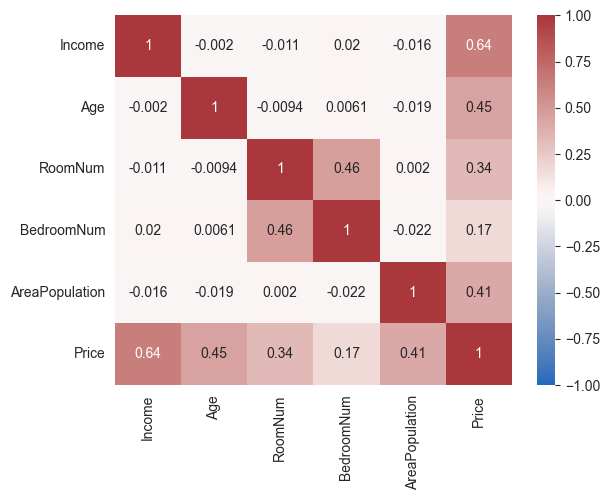

In [8]:
sns.heatmap(df.corr(), vmin=-1, vmax=1, annot=True, cmap="vlag")

Распределение без выбросов, кроме количества комнат.

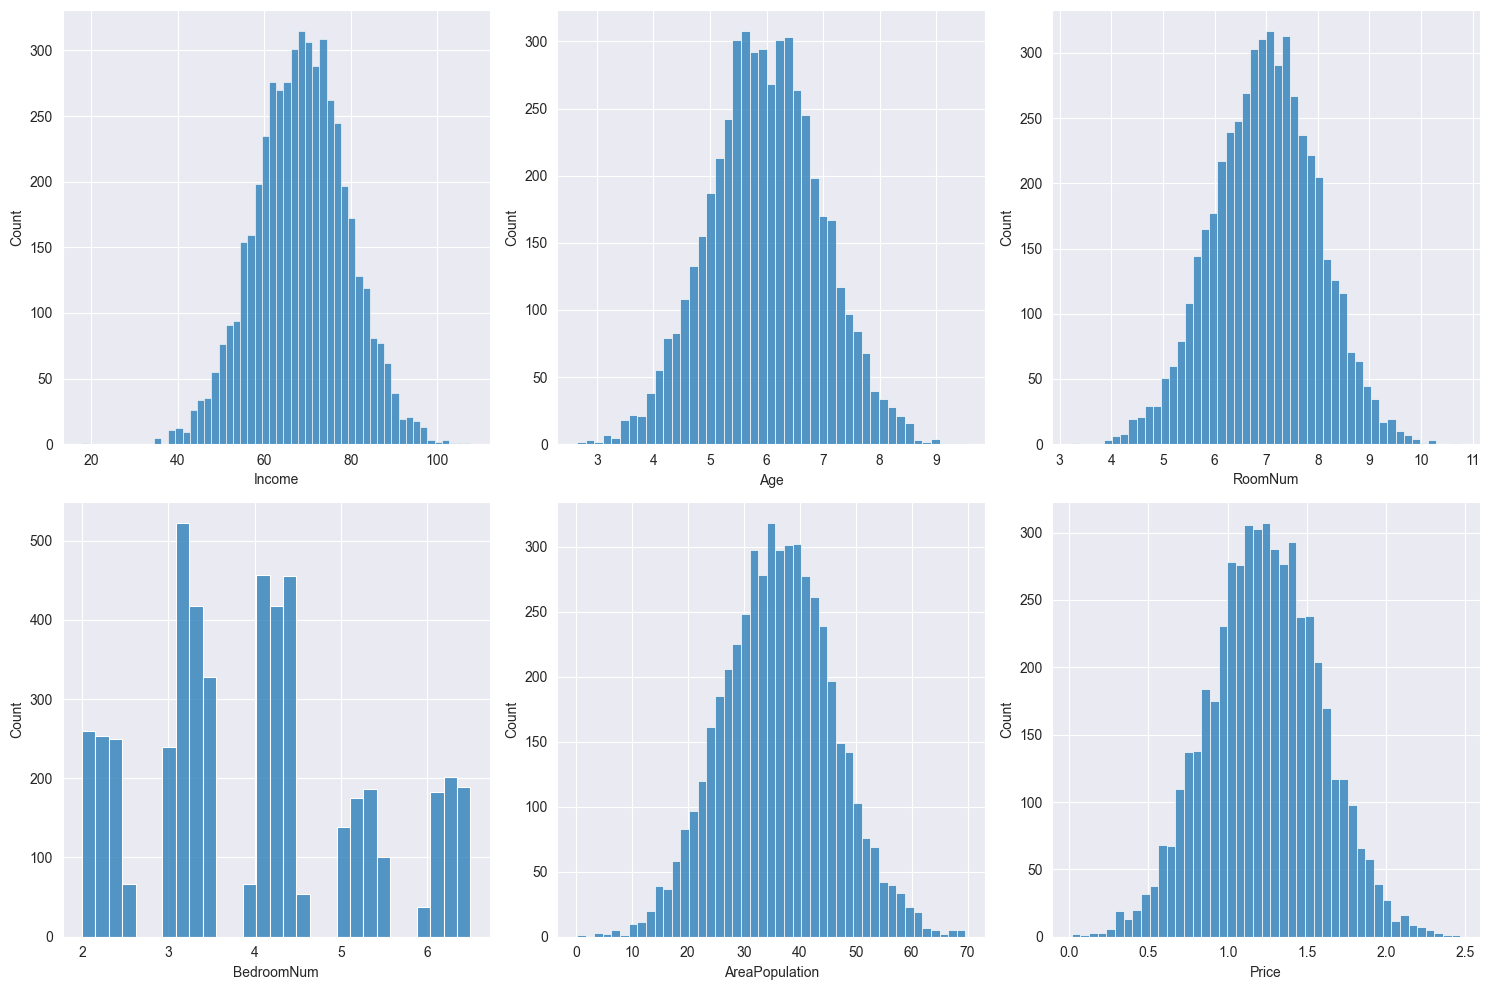

In [9]:
fig = plt.figure(figsize=(15, 10), tight_layout=True)
gs = fig.add_gridspec(2, 3)
for i in range(2):
    for j in range(3):
        sns.histplot(df[df.columns[3 * i + j]], ax=fig.add_subplot(gs[i, j]))

Выделяются 5 четких групп, но делить на них особого смысла нет, так как цена от группы к другой практически не меняется.

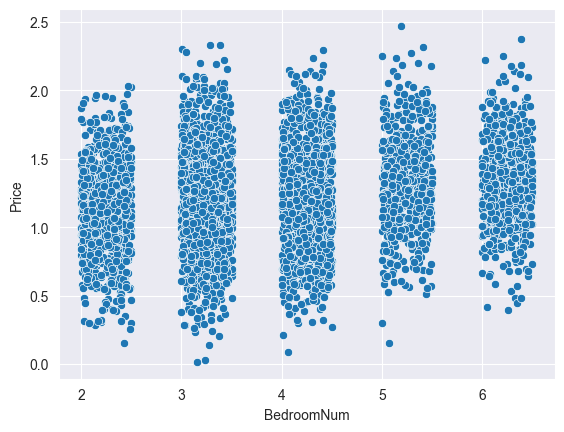

In [10]:
g = sns.scatterplot(data=df, x="BedroomNum", y="Price")

## Подбор наилучшего подмножества признаков
Таблица корреляции показала, что все признаки влияют на целевой. Попытаемся сузить множество признаков при помощи RFE.

In [11]:
X, y = df.drop(columns="Price"), df["Price"]

In [12]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.feature_selection import RFECV

rfecv = RFECV(
    estimator=Pipeline([("scaler", StandardScaler()), ("regressor", Ridge())]),
    importance_getter=lambda m: m.named_steps["regressor"].coef_,
)
rfecv.fit(X, y);

В результате предлагает убрать признак BedroomNum.

In [13]:
print(f"Optimal number of features = {rfecv.n_features_}")
print(f'Selected features = {list(X.columns[rfecv.support_])}')

Optimal number of features = 4
Selected features = ['Income', 'Age', 'RoomNum', 'AreaPopulation']


Действительно последний признак уже не важен.

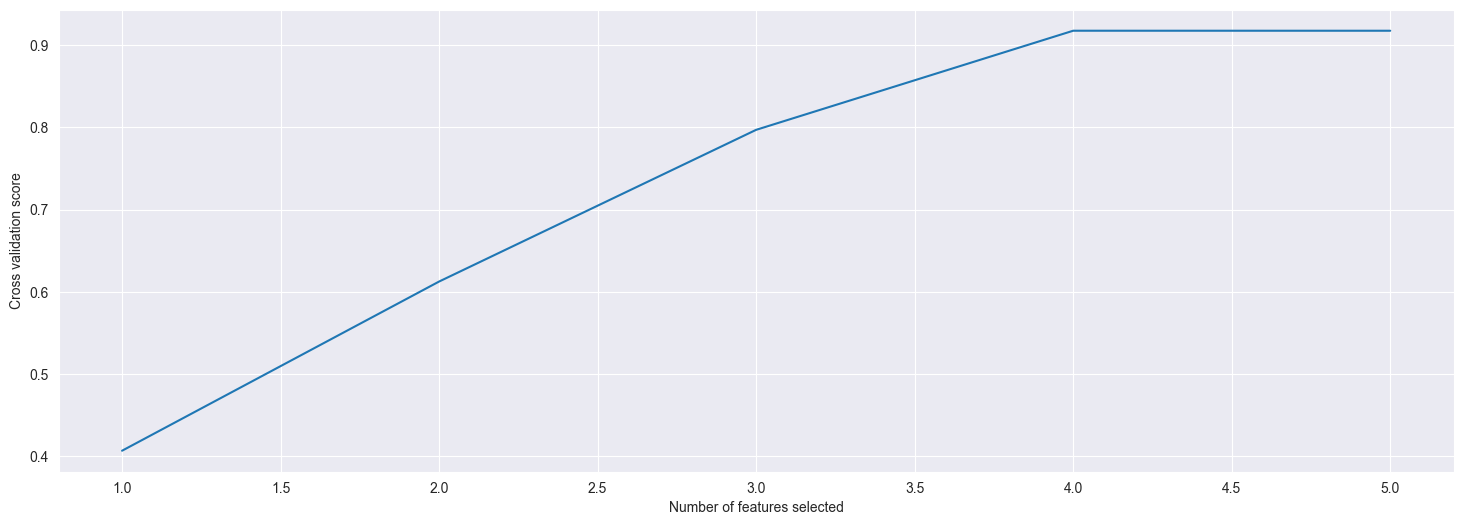

In [14]:
plt.figure(figsize=(18, 6))
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score")
plt.plot(range(1, len(rfecv.cv_results_["mean_test_score"]) + 1), rfecv.cv_results_["mean_test_score"])
plt.show()

In [15]:
X = X.drop(columns="BedroomNum")

## Реализации линейной регрессии
Будем использовать несколько реализаций.

### Batch Gradient Descent, GD

In [16]:
class AbstractLinearRegressor(BaseEstimator, RegressorMixin, abc.ABC):
    """ Abstract class implementing abstract gradient descent. """

    def __init__(
            self,
            alpha=1.0,
            max_iter=100,
            tol=1e-4,
            eta=0.1
    ):
        self.alpha = alpha
        self.max_iter = max_iter
        self.tol = tol
        self.eta = eta

    @abc.abstractmethod
    def _batch(
            self,
            X: npt.ArrayLike,
            y: npt.ArrayLike
    ) -> (npt.ArrayLike, npt.ArrayLike):
        ...

    def _check(self):
        check_scalar(self.alpha, "alpha", Real, min_val=0.0)
        check_scalar(self.max_iter, "max_iter", Integral, min_val=1)
        check_scalar(self.tol, "tol", Real, min_val=0.0)
        check_scalar(self.eta, "eta", Real, min_val=0)

    def fit(
            self,
            X: npt.ArrayLike,
            y: npt.ArrayLike
    ) -> "AbstractLinearRegressor":
        X, y = check_X_y(X, y, y_numeric=True)
        self.n_features_in_ = X.shape[1]
        X = np.column_stack([X, np.ones(X.shape[0])])

        coef = np.zeros(X.shape[1])
        grad = np.inf
        self.n_iter_ = 0
        while self.n_iter_ < self.max_iter and np.linalg.norm(grad) > self.tol:
            X_, y_ = self._batch(X, y)
            pred = X_ @ coef
            grad = (2 / X_.shape[0]) * X_.T @ (pred - y_) + 2 * self.alpha * np.pad(coef[:-1], (0, 1))
            self.n_iter_ += 1
            coef -= grad * self.eta / self.n_iter_

        self.coef_ = coef[:-1]
        self.intercept_ = coef[-1]
        return self

    def predict(
            self,
            X: npt.ArrayLike
    ) -> npt.NDArray:
        check_is_fitted(self)
        X = check_array(X)
        return X @ self.coef_ + self.intercept_


class GDLinearRegressor(AbstractLinearRegressor):
    def _batch(
            self,
            X: npt.ArrayLike,
            y: npt.ArrayLike
    ) -> (npt.ArrayLike, npt.ArrayLike):
        return X, y


# Совместимость с scikit-learn
check_estimator(GDLinearRegressor())

### Mini Batch Gradient Descent, MBGD

In [17]:
class MBGDLinearRegressor(AbstractLinearRegressor):
    def __init__(
            self,
            alpha=1.0,
            max_iter=100,
            tol=1e-4,
            eta=0.1,
            batch_size=0.1,
            random_state=None):
        self.batch_size = batch_size
        self.random_state = random_state
        super().__init__(alpha, max_iter=max_iter, tol=tol, eta=eta)

    def _batch(
            self,
            X: npt.ArrayLike,
            y: npt.ArrayLike
    ) -> (npt.ArrayLike, npt.ArrayLike):
        size = self.batch_size if isinstance(self.batch_size, int) else ceil(len(X) * self.batch_size)
        idx = self.random_state_.randint(len(X), size=size)
        return X[idx, :], y[idx]

    def _check(self):
        super()._check()
        check_scalar(self.batch_size, "batch_size", (float, int), min_val=0)

    def fit(self, X: npt.ArrayLike, y: npt.ArrayLike):
        self.random_state_ = check_random_state(self.random_state)
        return super().fit(X, y)


# Совместимость с scikit-learn
check_estimator(MBGDLinearRegressor())

### Stochastic Gradient Descent, SGD

In [18]:
class SGDLinearRegressor(MBGDLinearRegressor):
    def __init__(
            self,
            alpha=1.0,
            max_iter=100,
            tol=1e-4,
            eta=0.1,
            random_state=None
    ):
        super().__init__(
            alpha=alpha,
            max_iter=max_iter,
            tol=tol,
            eta=eta,
            batch_size=1,
            random_state=random_state
        )


# Совместимость с scikit-learn
check_estimator(SGDLinearRegressor())

### Ridge sklearn
Для сравнения будем также использовать уже реализованную библиотеку Ridge.

## Обучение
Случайным образом разобьем данные на обучающую и тестовую выборки.

In [19]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [20]:
regressors = {
    "Ridge": Ridge(random_state=42),
    "GD": GDLinearRegressor(),
    "Mini-batch": MBGDLinearRegressor(random_state=42),
    "Stochastic": SGDLinearRegressor(random_state=42)
}

### Масштабирование данных

In [21]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

### Обучение без подбора гиперпараметров и кросс-валидации

In [22]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score


def train(regressor, name: str):
    regressor.fit(X_train, y_train)

    pred = regressor.predict(X_train)
    mse_train = mean_squared_error(y_train, pred)
    rmse_train = mean_squared_error(y_train, pred, squared=False)
    r2_train = r2_score(y_train, pred)

    pred = regressor.predict(X_test)
    mse_test = mean_squared_error(y_test, pred)
    rmse_test = mean_squared_error(y_test, pred, squared=False)
    r2_test = r2_score(y_test, pred)

    return [name, mse_train, mse_test, rmse_train, rmse_test, r2_train, r2_test]



In [23]:
result1 = []

for name, regressor in regressors.items():
    result1.append(train(regressor, name))

In [24]:
pd.DataFrame(
    result1,
    columns=["Estimator", "MSE train", "MSE test", "RMSE train", "RMSE test", "R2 train", "R2 test"]
).set_index("Estimator")

,MSE train,MSE test,RMSE train,RMSE test,R2 train,R2 test
Estimator,,,,,,
Ridge,0.010263,0.010310,0.101308,0.101539,0.917923,0.916200
GD,0.223081,0.231747,0.472314,0.481401,-0.784010,-0.883627
Mini-batch,0.225189,0.233861,0.474540,0.483592,-0.800866,-0.900811
Stochastic,0.249100,0.257039,0.499099,0.506990,-0.992087,-1.089200


С дефолтными гиперпараметрами откровенно все плохо, так как R2 отрицательные. 

### Подбор гиперпараметров и кросс-валидация

In [55]:
from sklearn.model_selection import GridSearchCV


def search_grid(regressor, regressor_name, grids):
    cv = GridSearchCV(
        regressor,
        grids,
        scoring=[
            "neg_mean_squared_error",
            "neg_root_mean_squared_error",
            "r2"
        ],
        refit="neg_mean_squared_error",
        return_train_score=True
    )
    cv.fit(X_train, y_train)

    print(regressor_name)
    print("Best params - ", end="")
    print(cv.best_params_)
    print("Fit time:", f"{cv.refit_time_:.3f}", "sec")
    
    data = []
    index = []
    res = pd.DataFrame(cv.cv_results_).iloc[cv.best_index_]
    for suffix, metric, sign in [
        ("neg_mean_squared_error", "MSE", -1),
        ("neg_root_mean_squared_error", "RMSE", -1),
        ("r2", "R2", 1)
    ]:
        for piece in ["train", "test"]:
            row = []
            for i in range(5):
                row.append(sign * res[f"split{i}_{piece}_{suffix}"])
            row.append(sign * res[f"mean_{piece}_{suffix}"])
            row.append(res[f"std_{piece}_{suffix}"])
            data.append(row)
            index.append(f"{metric} {piece}")
    return pd.DataFrame(
        data=data,
        index=index,
        columns=["Fold 1", "Fold 2", "Fold 3", "Fold 4", "Fold 5", "Mean", "STD"]
    )

In [56]:
search_grid(Ridge(random_state=42), "Ridge", {"alpha": np.logspace(0, -1, 10), "tol": [1e-6, 1e-5, 1e-4]})

Ridge
Best params - {'alpha': 1.0, 'tol': 1e-06}
Fit time: 0.003 sec


,Fold 1,Fold 2,Fold 3,Fold 4,Fold 5,Mean,STD
MSE train,0.0103,0.0102,0.0103,0.0101,0.0104,0.0103,0.0001
MSE test,0.0102,0.0106,0.0101,0.0107,0.0099,0.0103,0.0003
RMSE train,0.1014,0.1009,0.1015,0.1007,0.1018,0.1013,0.0004
RMSE test,0.1010,0.1028,0.1005,0.1036,0.0994,0.1015,0.0015
R2 train,0.9189,0.9197,0.9175,0.9171,0.9164,0.9179,0.0012
R2 test,0.9134,0.9099,0.9192,0.9207,0.9237,0.9174,0.0050


In [64]:
search_grid(GDLinearRegressor(), "GD", {"alpha": np.logspace(0, -1, 10), "tol": [1e-6, 1e-5, 1e-4], "eta": [10.0, 1.0, 0.1]})

GD
Best params - {'alpha': 0.1, 'eta': 10.0, 'tol': 0.0001}
Fit time: 0.016 sec


,Fold 1,Fold 2,Fold 3,Fold 4,Fold 5,Mean,STD
MSE train,0.0113,0.0112,0.0113,0.0112,0.0114,0.0113,0.0001
MSE test,0.0110,0.0115,0.0116,0.0115,0.0109,0.0113,0.0003
RMSE train,0.1062,0.1058,0.1063,0.1058,0.1067,0.1061,0.0003
RMSE test,0.1049,0.1070,0.1076,0.1073,0.1046,0.1063,0.0013
R2 train,0.9111,0.9119,0.9096,0.9086,0.9082,0.9099,0.0014
R2 test,0.9065,0.9024,0.9074,0.9149,0.9155,0.9093,0.0051


In [61]:
search_grid(MBGDLinearRegressor(random_state=42), "MBGD",
            {"alpha": np.logspace(0, -1, 10), "tol": [1e-6, 1e-5, 1e-4], "eta": [10, 1.0, 0.1],
             "batch_size": [0.001, 0.1, 1]})

MBGD
Best params - {'alpha': 0.1, 'batch_size': 0.001, 'eta': 1.0, 'tol': 1e-06}
Fit time: 0.016 sec


,Fold 1,Fold 2,Fold 3,Fold 4,Fold 5,Mean,STD
MSE train,0.0109,0.0112,0.0110,0.0109,0.0111,0.0110,0.0001
MSE test,0.0108,0.0114,0.0112,0.0112,0.0106,0.0111,0.0003
RMSE train,0.1044,0.1057,0.1050,0.1044,0.1052,0.1049,0.0005
RMSE test,0.1042,0.1066,0.1058,0.1060,0.1030,0.1051,0.0013
R2 train,0.9141,0.9120,0.9118,0.9110,0.9107,0.9119,0.0012
R2 test,0.9078,0.9031,0.9105,0.9171,0.9180,0.9113,0.0057


In [63]:
search_grid(SGDLinearRegressor(random_state=42), "SGD",
            {"alpha": np.logspace(0, -1, 10), "tol": [1e-6, 1e-5, 1e-4], "eta": [10, 1.0, 0.1]})

SGD
Best params - {'alpha': 0.1668100537200059, 'eta': 1.0, 'tol': 1e-06}
Fit time: 0.016 sec


,Fold 1,Fold 2,Fold 3,Fold 4,Fold 5,Mean,STD
MSE train,0.0169,0.0156,0.0132,0.0133,0.0151,0.0148,0.0014
MSE test,0.0188,0.0158,0.0132,0.0132,0.0149,0.0152,0.0021
RMSE train,0.1299,0.1250,0.1149,0.1153,0.1228,0.1216,0.0058
RMSE test,0.1371,0.1258,0.1151,0.1147,0.1219,0.1229,0.0082
R2 train,0.8671,0.8768,0.8944,0.8914,0.8782,0.8816,0.0101
R2 test,0.8401,0.8651,0.8941,0.9028,0.8853,0.8775,0.0225


In [49]:
regressors = {
    "Ridge": Ridge(random_state=42, alpha=1.0, tol=1e-06),
    "GD": GDLinearRegressor(alpha=0.1, tol=0.0001, eta=10.0),
    "Mini-batch": MBGDLinearRegressor(alpha=0.1, tol=1e-06, eta=1.0, batch_size=0.001),
    "Stochastic": SGDLinearRegressor(alpha=0.1668100537200059, tol=1e-06, eta=1.0)
}

In [50]:
result2 = []

for name, regressor in regressors.items():
    result2.append(train(regressor, name))

In [51]:
pd.options.display.float_format = "{:,.4f}".format
pd.DataFrame(
    result2,
    columns=["Estimator", "MSE train", "MSE test", "RMSE train", "RMSE test", "R2 train", "R2 test"]
).set_index("Estimator")

,MSE train,MSE test,RMSE train,RMSE test,R2 train,R2 test
Estimator,,,,,,
Ridge,0.0103,0.0103,0.1013,0.1015,0.9179,0.9162
GD,0.0113,0.0109,0.1062,0.1042,0.9099,0.9117
Mini-batch,0.0120,0.0116,0.1095,0.1078,0.9041,0.9056
Stochastic,0.0159,0.0160,0.1259,0.1265,0.8732,0.8699


После подбора значение метрик почти сравнялись у всех реализаций.

### Выводы

1. Модель scikit-learn Ridge показала одинаковые результаты как с кросс-валидацией и подбора гиперпараметров (КВ и ПГ), так и без них.
2. Реализованные модели без КВ и ПГ показали себя очень плохо (R2 даже для тестовых данных был отрицателен)
3. Реализованные модели с КВ и ПГ приблизили метрики к модели scikit-learn Ridge. Самая близкая по всем метрикам оказалась модель GD.
4. По времени все модели показали себя одинаково, видимо из-за маленького размера датасета. Но заметно медленнее чем Ridge.
5. Стохастический градиентный спуск показал себя хуже остальных (все метрики заметно хуже).